# package & data

In [1]:
import astropy.units as u
import numpy as np
from astropy.io import fits 

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches4
from matplotlib import colors
import matplotlib.patches as mpatches

import scipy.constants as C
import scipy.interpolate as spi

from itertools import product

import warnings
from scipy.signal import find_peaks

from scipy import integrate
from scipy.optimize import curve_fit

import random

In [126]:
?curve_fit

In [2]:
### read data

sdssj0228 = fits.open("data/SDSSJ022849.51-090153.8_DATACUBE_FINAL_2019-10-20T08.23.58.345.fits")
spec_data = sdssj0228[1].data
spec_err = sdssj0228[2].data
min_wave = sdssj0228[0].header['WAVELMIN']*10
max_wave = sdssj0228[0].header['WAVELMAX']*10
wave_len = np.linspace(min_wave,max_wave,spec_data.shape[0])
wavelength = wave_len/(1+0.072)
mask_pp = (wavelength > 4800) & (wavelength < 7409)

ppdata = fits.open("ppxf/SDSSJ0228/SDSSJ0228_mask_ppxf_fitdata.fits")
pp_galaxy = ppdata[4].data
pp_bestfit = ppdata[2].data
pp_wave = ppdata[1].data["wavelength"]

rebin_data_Ha = fits.open('analyse_data_image/SDSSJ0228/SDSSJ0228_rebin_specHa_10.fits')
spec_flux_rebin_Ha = rebin_data_Ha[1].data
spec_err_rebin_Ha = rebin_data_Ha[2].data
spec_con_rebin_Ha = rebin_data_Ha[3].data
spec_flux_Ha = spec_flux_rebin_Ha[:,25,25]
spec_err_Ha = spec_err_rebin_Ha[:,25,25]
spec_con_Ha = spec_con_rebin_Ha[:,25,25]

In [129]:
spec_err_Ha.shape == spec_flux_Ha.shape

True

# function 1 

In [3]:
#### 计算峰值信噪比
def peak_SNR(wave,spec_flux,spec_error,vorbin,emline='S2'):
    
    if wave.shape[0] == spec_flux.shape[0]:
        pass
    else:
        print('wavelength and spectra data must be same size!')
    
    if emline=='S2':
        peak_wave = 6724
        m_peak = np.where(np.abs(wave-peak_wave)<14)
    elif emline=='Ha':
        peak_wave = 6562.80
        m_peak = np.where(np.abs(wave-peak_wave)<10)
    elif emline=='Hb':
        peak_wave = 4861.33
        m_peak = np.where(np.abs(wave-peak_wave)<10)
    elif emline=='N2a':
        peak_wave = 6548.03
        m_peak = np.where(np.abs(wave-peak_wave)<10)
    elif emline=='N2b':
        peak_wave = 6583.41
        m_peak = np.where(np.abs(wave-peak_wave)<10)
    elif emline=='O3a':
        peak_wave = 4958.92
        m_peak = np.where(np.abs(wave-peak_wave)<10)
    elif emline=='O3b':
        peak_wave = 5006.84
        m_peak = np.where(np.abs(wave-peak_wave)<10)
        
    emline_data = spec_flux[m_peak]
    emline_error = spec_error[m_peak]
    indices = find_peaks(emline_data, height=10,distance=15,prominence=10)
    peak_flux = emline_data[indices[0]]
    peak_error = emline_error[indices[0]]
    snr = signal/noise
    
    name = ['signal','noise','SNR']
    sn = [peak_flux,peak_error,snr]
    peak_SNR = dict(zip(name, sn))
    
    return peak_SNR

In [4]:
#### 高斯模型
def gaussian(x,*p):
    model = p[0]*np.exp(-0.5*(x - p[1])**2/p[2]**2)  
    for i in range(3,len(p),3):
        amp = p[i]
        mean = p[i+1]
        sigma = p[i+2]
        model += amp*np.exp(-0.5*(x - mean)**2/sigma**2) 
        
    return model

In [149]:
## 根据给定单高斯参数计算积分流量，流量误差，线心速度，外流宽线的W80
def single_gauss_calculate(wave,spec_error,spec_con,*p,linetype='narrow',vmode=None):
    #### single gauss function 
    def make_gauss(amp, mean, sigma):
        s = -1.0 / (2 * sigma * sigma)
        def f(x):
            return amp* np.exp(s * (x - mean)*(x - mean))
        return f
    
    amp = p[0]
    mean = p[1]
    sigma = p[2]
    fwhm = 2.355*sigma
    
    if linetype == 'narrow':
        ### flux & flux error
        flux,integrate_err = integrate.quad(make_gauss(amp,mean,sigma), mean-3*fwhm, mean+3*fwhm)
        mask = (wave>mean-3*fwhm)&(wave<mean+3*fwhm)
        flux_err_spec = np.sqrt(np.nansum((spec_error[mask])**2))
        flux_err = np.sqrt(integrate_err**2 + flux_err_spec**2)
        ### equivalentwidth
        ew = flux/np.median(spec_con)
        ### velocity
        if vmode == None:
            v = np.nan
        if vmode == 'Ha':
            xc = 6562.8
            v = ((mean-xc)/xc)*3*10**5
        if vmode == 'Hb':
            xc = 4861.3
            v = ((mean-xc)/xc)*3*10**5
        if vmode == 'O3a':
            xc = 4958.92
            v = ((mean-xc)/xc)*3*10**5
        if vmode == 'O3b':
            xc = 5006.84
            v = ((mean-xc)/xc)*3*10**5
        
        ### output 
        name = ['flux','flux_error','velocity','equivalentwidth']
        em_data = [flux,flux_err,v,ew]
        emline_data = dict(zip(name,em_data))
        return emline_data
    
    if linetype == 'broad':
        ### flux & flux error
        flux,integrate_err = integrate.quad(make_gauss(amp,mean,sigma), mean-3*fwhm, mean+1*fwhm)
        mask = (wave>mean-3*fwhm)&(wave<mean+1*fwhm)
        flux_err_spec = np.sqrt(np.nansum((spec_error[mask])**2))
        flux_err = np.sqrt(integrate_err**2 + flux_err_spec**2)
        ### equivalentwidth
        ew = flux/np.median(spec_con)
        ### velocity
        if vmode == None:
            v = np.nan
        if vmode == 'Ha':
            xc = 6562.8
            v = ((mean-xc)/xc)*3*10**5
        if vmode == 'Hb':
            xc = 4861.3
            v = ((mean-xc)/xc)*3*10**5
        if vmode == 'O3a':
            xc = 4958.92
            v50 = ((mean-xc)/xc)*3*10**5
            v80 = (((mean-1.09*fwhm)-xc)/xc)*3*10**5
            v_name = ['v50','v80']
            v_data = [v50,v80]
            v = dict(zip(v_name,v_data))
        if vmode == 'O3b':
            xc = 5006.84
            v50 = ((mean-xc)/xc)*3*10**5
            v80 = (((mean-1.09*fwhm)-xc)/xc)*3*10**5
            v_name = ['v50','v80']
            v_data = [v50,v80]
            v = dict(zip(v_name,v_data))
        ### output 
        name = ['flux','flux_error','velocity','equivalentwidth']
        em_data = [flux,flux_err,v,ew]
        emline_data = dict(zip(name,em_data))
        return emline_data   

In [74]:
### 根据参数计算，速度
def emline_fit_properties(wave,spec_error,spec_con,para,mode='Ha'):
    
    line_num = len(para)/3
    p_t = np.split(para,line_num)
    
    flux = []
    flux_err = []
    v = []
    ew = []

    if mode == 'Ha':
        for j in range(0,len(p_t)):
            p_j = p_t[j]
            emline_data = single_gauss_calculate(wave,spec_error,spec_con,*p_j,linetype='narrow',vmode='Ha') 
            flux.append(emline_data['flux'])
            flux_err.append(emline_data['flux_error'])
            v.append(emline_data['velocity'])
            ew.append(emline_data['equivalentwidth'])
        if line_num == 3:
            names = ['NII[6548]','Ha[6563]','NII[6583]']
        else:
            names = ['NII[6548]','Ha[6563]','NII[6583]','Ha[6563]_broad']
            
    if mode == 'Hb':
        for j in range(0,len(p_t)):
            p_j = p_t[j]
            emline_data = single_gauss_calculate(wave,spec_error,spec_con,*p_j,linetype='narrow',vmode='Hb') 
            flux.append(emline_data['flux'])
            flux_err.append(emline_data['flux_error'])
            v.append(emline_data['velocity'])
            ew.append(emline_data['equivalentwidth'])
    
        if line_num == 1:
            names = ['Hb[4861]']
        else:
            names = ['Hb[4861]','Hb[4861]_broad']

    if mode == 'O3a':
        if line_num == 1:
            p_j = p_t[0]
            emline_data = single_gauss_calculate(wave,spec_error,spec_con,*p_j,linetype='narrow',vmode='O3a') 
            flux.append(emline_data['flux'])
            flux_err.append(emline_data['flux_error'])
            v.append(emline_data['velocity'])
            ew.append(emline_data['equivalentwidth'])
            names = ['OIII[4959]']
        else:
            p_narrow = p_t[0]
            p_broad = p_t[1]
            narrow_data = single_gauss_calculate(wave,spec_error,spec_con,*p_narrow,linetype='narrow',vmode='O3a') 
            broad_data  = single_gauss_calculate(wave,spec_error,spec_con,*p_broad,linetype='broad',vmode='O3a') 
            flux = [narrow_data['flux'],broad_data['flux']]
            flux_err = [narrow_data['flux_error'],broad_data['flux_error']]
            v = [narrow_data['velocity'],broad_data['velocity']]
            ew = [narrow_data['equivalentwidth'],broad_data['equivalentwidth']]
            names = ['OIII[4959]','OIII[4959]_broad']

    if mode == 'O3b':
        if line_num == 1:
            p_j = p_t[0]
            emline_data = single_gauss_calculate(wave,spec_error,spec_con,*p_j,linetype='narrow',vmode='O3b')
            flux.append(emline_data['flux'])
            flux_err.append(emline_data['flux_error'])
            v.append(emline_data['velocity'])
            ew.append(emline_data['equivalentwidth'])
            names = ['OIII[5007]']
        else:
            p_narrow = p_t[0]
            p_broad = p_t[1]
            narrow_data = single_gauss_calculate(wave,spec_error,spec_con,*p_narrow,linetype='narrow',vmode='O3b') 
            broad_data  = single_gauss_calculate(wave,spec_error,spec_con,*p_broad,linetype='broad',vmode='O3b')
            flux = [narrow_data['flux'],broad_data['flux']]
            flux_err = [narrow_data['flux_error'],broad_data['flux_error']]
            v = [narrow_data['velocity'],broad_data['velocity']]
            ew = [narrow_data['equivalentwidth'],broad_data['equivalentwidth']]
            names = ['OIII[5007]','OIII[5007]_broad']
            
    if mode == 'S2':
        for j in range(0,len(p_t)):
            p_j = p_t[j]
            emline_data = single_gauss_calculate(wave,spec_error,spec_con,*p_j,linetype='narrow',vmode='S2') 
            flux.append(emline_data['flux'])
            flux_err.append(emline_data['flux_error'])
            v.append(emline_data['velocity'])
            ew.append(emline_data['equivalentwidth'])
        names = ['SII[6717]','SII[6731]']
        
            
    ######## output
    line_flux = [names[i]+'_flux' for i in range(len(names))]
    line_err = [names[i]+'_fluxerr' for i in range(len(names))]
    line_v = [names[i]+'_velocity' for i in range(len(names))]
    line_ew = [names[i]+'_EW' for i in range(len(names))]
        
    emline_flux = dict(zip(line_flux, flux))
    emline_flux_err = dict(zip(line_err, flux_err))
    emline_v = dict(zip(line_v, v))
    emline_ew = dict(zip(line_ew, ew))
    fit_flux = emline_flux
    fit_flux.update(emline_flux_err)
    fit_flux.update(emline_v)
    fit_flux.update(emline_ew)
    return fit_flux

In [140]:
def emline_fit_status(fit_wave,fitspec_flux,fitspec_err,para,para_err,mode='Ha'):

    para_error = np.sqrt(np.diag(para_err))
    chi2 = np.sum((fitspec_flux-gaussian(fit_wave,*para))**2/fitspec_err**2)
    reduced_chi2 = chi2/(fit_wave.shape[0] - para.shape[0])
    line_num = len(para)/3
    fit_para = np.split(para,line_num)
    fit_para_err = np.split(para_error,line_num)
    
    if mode == 'Ha':
        if line_num == 3:
            names = ['NII[6548]','Ha[6563]','NII[6583]']
        else:
            names = ['NII[6548]','Ha[6563]','NII[6583]','Ha[6563]_broad']
    if mode == 'Hb':
        if line_num == 1:
            names = ['Hb[4861]']
        else:
            names = ['Hb[4861]','Hb[4861]_broad']
    if mode == 'O3a':
        if line_num == 1:
            names = ['OIII[4959]']
        else:
            names = ['OIII[4959]','OIII[4959]_broad']
    if mode == 'O3b':
        if line_num == 1:
            names = ['OIII[5007]']
        else:
            names = ['OIII[5007]','OIII[5007]_broad']
    if mode == 'S2':
        names = ['SII[6717]','SII[6731]']
        
    line_para = [names[i]+'_para' for i in range(len(names))]
    line_paraerr = [names[i]+'_perr' for i in range(len(names))]
    line_chi2 = ['fit_Chi2','fit_rChi2']
    fit_p = dict(zip(line_para, fit_para))
    fit_perr = dict(zip(line_paraerr, fit_para_err))
    fit_chi2 = dict(zip(line_chi2, [chi2,reduced_chi2]))
    fit_status = fit_p
    fit_status.update(fit_perr)
    fit_status.update(fit_chi2)
    
    return fit_status

In [141]:
def emline_amp(wave,flux,names,window=10):
    
    emline_names = ['NII[6548]','Ha[6563]','NII[6583]','Hb[4861]',
                    'OIII[4959]','OIII[5007]','SII[6717]','SII[6731]']
    emline_wave = [6548. ,6563. ,6583. ,4861. ,4959. ,5007. ,6717. ,6731.]

    Amp = []
    for i in names:
        idx_i = emline_names.index(i)
        lam_i = emline_wave[idx_i]
        mask_i = np.where(np.abs(wave-lam_i)<window)
        emline_data = flux[mask_i]
        indices = find_peaks(emline_data, height=10,distance=15,prominence=10)
        peak_flux = emline_data[indices[0]]
        Amp.append(peak_flux)
        
    return Amp

In [150]:
def emline_fit(wave,spec_flux,spec_error,continuum,
               plot=True,savefig=False,py=0,px=0,
               mode='Ha',maxfev=500000):
    """
    comments
    
    """
    galaxy_wave = wave
    galaxy_flux = spec_flux
    galaxy_err = spec_error
    galaxy_con = continuum
    
    if mode == 'Ha':
        #################    set Initial value    ############################
        name = ['NII[6548]','Ha[6563]','NII[6583]']
        Amp = emline_amp(galaxy_wave,galaxy_flux,name,window=10)
        mask_Ha = ((galaxy_wave > 6530) & (galaxy_wave < 6610))
        fit_wave = galaxy_wave[mask_Ha]
        fit_spec = galaxy_flux[mask_Ha]
        fit_err = galaxy_err[mask_Ha]
        fit_con = galaxy_con[mask_Ha]
        ################    narrow line    ############################
        p0 = np.array([Amp[0], 6548., 1.,
                       Amp[1], 6563., 1.,
                       Amp[2], 6584., 1.])
        p0_bounds = ([0,6543,0,0,6558.5,0,0,6578,0],
                     [Amp[0],6553,2,Amp[1],6567.5,3,Amp[2],6588,2])
        popt_n,pcov_n = curve_fit(gaussian,fit_wave,fit_spec,p0=p0,bounds=p0_bounds,
                             sigma=fit_err,absolute_sigma=True,maxfev=maxfev)
        fit_status_narrow = emline_fit_status(fit_wave,fit_spec,fit_err,popt_n,pcov_n,mode='Ha')
        ###################    broad line    #############################
        p0_b = np.array([Amp[0], 6548., 1.,
                          Amp[1], 6563., 1.,
                          Amp[2], 6584., 1.,
                          Amp[1], 6563., 3.])
        p0_b_bounds = ([0,6543,0,0,6557,0,0,6578,0,0,6557,2],
                       [Amp[0],6553,2,Amp[1],6567,3,Amp[2],6588,2,Amp[1],6567,5])
        popt_b,pcov_b = curve_fit(gaussian,fit_wave,fit_spec,p0=p0_b,bounds=p0_b_bounds,
                             sigma=fit_err,absolute_sigma=True,maxfev=maxfev)
        fit_status_broad = emline_fit_status(fit_wave,fit_spec,fit_err,popt_b,pcov_b,mode='Ha')
        ######################    compare fit results ##########################
        diff_chi2 = fit_status_narrow['fit_Chi2'] -  fit_status_broad['fit_Chi2']
        if diff_chi2 < 14:
            popt = popt_n
            pcov = pcov_n
            fit_status =  emline_fit_status(fit_wave,fit_spec,fit_err,popt,pcov,mode='Ha')
            fit_flux = emline_fit_properties(galaxy_wave,galaxy_err,fit_con,popt,mode='Ha')
        else:
            popt = popt_b
            pcov = pcov_b
            fit_status =  emline_fit_status(fit_wave,fit_spec,fit_err,popt,pcov,mode='Ha')
            fit_flux = emline_fit_properties(galaxy_wave,galaxy_err,fit_con,popt,mode='Ha')
    
    if mode == 'Hb':
        #################    set Initial value    ############################
        name = ['Hb[4861]']
        Amp = emline_amp(galaxy_wave,galaxy_flux,name,window=10)
        mask_Hb  = (galaxy_wave > 4830) & (galaxy_wave < 4890)
        fit_wave = galaxy_wave[mask_Hb]
        fit_spec = galaxy_flux[mask_Hb]
        fit_err  = galaxy_err[mask_Hb]
        fit_con = galaxy_con[mask_Hb]
        ################    narrow line    ############################
        p0 = np.array([Amp[0],4862.,1.])
        p0_bounds = ([0,4856.,0.],
                     [np.inf,4868.,2.])
        popt_n,pcov_n = curve_fit(gaussian,fit_wave,fit_spec,p0=p0,bounds=p0_bounds,
                             sigma=fit_err,absolute_sigma=True,maxfev=maxfev)
        fit_status_narrow = emline_fit_status(fit_wave,fit_spec,fit_err,popt_n,pcov_n,mode='Hb')
        ###################    broad line    #############################
        p0_b = np.array([Amp[0],4862.,1.,
                           Amp[0],4862.,3.,])
        p0_b_bounds = ([0,4856,0,-np.inf,4856,2],
                        [np.inf ,4868,2, np.inf,4868,5])
        popt_b,pcov_b = curve_fit(gaussian,fit_wave,fit_spec,p0=p0_b,bounds=p0_b_bounds,
                             sigma=fit_err,absolute_sigma=True,maxfev=maxfev)
        fit_status_broad = emline_fit_status(fit_wave,fit_spec,fit_err,popt_b,pcov_b,mode='Hb')
        ######################    compare fit results ##########################
        diff_chi2 = fit_status_narrow['fit_Chi2'] -  fit_status_broad['fit_Chi2']
        if diff_chi2 < 12:
            popt = popt_n
            pcov = pcov_n
            fit_status =  emline_fit_status(fit_wave,fit_spec,fit_err,popt,pcov,mode='Hb')
            fit_flux = emline_fit_properties(galaxy_wave,galaxy_err,fit_con,popt,mode='Hb')
        else:
            popt = popt_b
            pcov = pcov_b
            fit_status =  emline_fit_status(fit_wave,fit_spec,fit_err,popt,pcov,mode='Hb')
            fit_flux = emline_fit_properties(galaxy_wave,galaxy_err,fit_con,popt,mode='Hb')
    
    if mode == 'O3':
        #################    set Initial value    ############################
        name = ['OIII[4959]','OIII[5007]']
        Amp = emline_amp(galaxy_wave,galaxy_flux,name,window=10)
        
        mask_OIIIa = ((galaxy_wave > 4935) & (galaxy_wave < 4975))
        mask_OIIIb = ((galaxy_wave > 4980) & (galaxy_wave < 5030))
        fitOIIIa_wave = galaxy_wave[mask_OIIIa]
        fitOIIIa_flux = galaxy_flux[mask_OIIIa]
        fitOIIIa_err = galaxy_err[mask_OIIIa]
        fitOIIIa_con = galaxy_con[mask_OIIIa]
        fitOIIIb_wave = galaxy_wave[mask_OIIIb]
        fitOIIIb_flux = galaxy_flux[mask_OIIIb]
        fitOIIIb_err = galaxy_err[mask_OIIIb]
        fitOIIIb_con = galaxy_con[mask_OIIIb]
        
        #################    OIII[4959]    ############################
        ################    narrow line    ############################
        p0_O3l_n = np.array([Amp[0],4957.,1.])
        p0_O3l_n_bounds = ([0.,4954.,0.],
                          [Amp[0],4960.,2.])
        popt_O3ln,pcov_O3ln = curve_fit(gaussian,fitOIIIa_wave,fitOIIIa_flux,p0=p0_O3l_n,bounds=p0_O3l_n_bounds,
                             sigma=fitOIIIa_err,absolute_sigma=True,maxfev=maxfev)
        fit_status_O3ln = emline_fit_status(fitOIIIa_wave,fitOIIIa_flux,fitOIIIa_err,popt_O3ln,pcov_O3ln,mode='O3a')
        ###################    broad line    #############################
        p0_O3l_b = np.array([Amp[0], 4957., 1.,
                            Amp[0], 4957., 3.])
        p0_O3l_b_bounds = ([0,4954,0,0,4954,2],
                          [Amp[0],4960,2,Amp[0],4960,5])
        popt_O3lb,pcov_O3lb = curve_fit(gaussian,fitOIIIa_wave,fitOIIIa_flux,p0=p0_O3l_b,bounds=p0_O3l_b_bounds,
                             sigma=fitOIIIa_err,absolute_sigma=True,maxfev=maxfev)
        fit_status_O3lb = emline_fit_status(fitOIIIa_wave,fitOIIIa_flux,fitOIIIa_err,popt_O3lb,pcov_O3lb,mode='O3a')
        
        diff_chi2 = fit_status_O3ln['fit_Chi2'] -  fit_status_O3lb['fit_Chi2']
        if diff_chi2 < 7:
            popt_l = popt_O3ln
            pcov_l = pcov_O3ln
            fit_status_O3l =  emline_fit_status(fitOIIIa_wave,fitOIIIa_wave,fitOIIIa_err,popt_l,pcov_l,mode='O3a')
            fit_flux_O3l = emline_fit_properties(galaxy_wave,galaxy_err,fitOIIIa_con,popt_l,mode='O3a')
        else:
            popt_l = popt_O3lb
            pcov_l = pcov_O3lb
            fit_status_O3l =  emline_fit_status(fitOIIIa_wave,fitOIIIa_wave,fitOIIIa_err,popt_l,pcov_l,mode='O3a')
            fit_flux_O3l = emline_fit_properties(galaxy_wave,galaxy_err,fitOIIIa_con,popt_l,mode='O3a')
        #################    OIII[5007]    #######################################
        ################    narrow line    ############################
        p0_O3r_n = np.array([Amp[1], 5007., 1.])
        p0_O3r_n_bounds = ([0,5004,0],
                           [Amp[1],5010,2])
        popt_O3rn,pcov_O3rn = curve_fit(gaussian,fitOIIIb_wave,fitOIIIb_flux,p0=p0_O3r_n,bounds=p0_O3r_n_bounds,
                             sigma=fitOIIIb_err,absolute_sigma=True,maxfev=maxfev)
        fit_status_O3rn = emline_fit_status(fitOIIIb_wave,fitOIIIb_flux,fitOIIIb_err,popt_O3rn,pcov_O3rn,mode='O3b')
        ###################    broad line    #############################
        p0_O3r_b = np.array([Amp[1], 5007., 1.,
                             Amp[1], 5007., 3.])
        p0_O3r_b_bounds = ([0,5004,0,0,5004,2],
                           [Amp[1],5010,2,Amp[1],5010,8])
        popt_O3rb,pcov_O3rb = curve_fit(gaussian,fitOIIIb_wave,fitOIIIb_flux,p0=p0_O3r_b,bounds=p0_O3r_b_bounds,
                             sigma=fitOIIIb_err,absolute_sigma=True,maxfev=maxfev)
        fit_status_O3rb = emline_fit_status(fitOIIIb_wave,fitOIIIb_flux,fitOIIIb_err,popt_O3rb,pcov_O3rb,mode='O3b')
        
        diff_chi2 = fit_status_O3rn['fit_Chi2'] -  fit_status_O3rb['fit_Chi2']
        if diff_chi2 < 9:
            popt_r = popt_O3rn
            pcov_r = pcov_O3rn
            fit_status_O3r =  emline_fit_status(fitOIIIb_wave,fitOIIIb_flux,fitOIIIb_err,popt_r,pcov_r,mode='O3b')
            fit_flux_O3r = emline_fit_properties(galaxy_wave,galaxy_err,fitOIIIb_con,popt_r,mode='O3b')
        else:
            popt_r = popt_O3rb
            pcov_r = pcov_O3rb
            fit_status_O3r =  emline_fit_status(fitOIIIb_wave,fitOIIIb_flux,fitOIIIb_err,popt_r,pcov_r,mode='O3b')
            fit_flux_O3r = emline_fit_properties(galaxy_wave,galaxy_err,fitOIIIb_con,popt_r,mode='O3b')

        fit_status = fit_status_O3l
        fit_status.update(fit_status_O3r)
        fit_flux = fit_flux_O3l
        fit_flux.update(fit_flux_O3r)
                
    if mode == 'S2':
        #################    set Initial value    ############################
        name = ['SII[6717]','SII[6731]']
        Amp = emline_amp(galaxy_wave,galaxy_flux,name,window=7)
        mask_SII = ((galaxy_wave > 6700) & (galaxy_wave < 6750))
        fit_wave = galaxy_wave[mask_SII]
        fit_spec = galaxy_flux[mask_SII]
        fit_err = galaxy_err[mask_SII]
        fit_con = galaxy_con[mask_SII]
        ########    start fitting 
        p0 = np.array([Amp[0], 6717., 1.,
                       Amp[1], 6731., 1.,])
        p0_bounds = ([0,6712,0,0,6726,0],
                     [np.inf,6722,2,np.inf,6736,2])
        popt,pcov = curve_fit(gaussian,fit_wave,fit_spec,p0=p0,bounds=p0_bounds,
                              sigma=fit_err,absolute_sigma=True,maxfev=maxfev)
        #########    fit results 
        fit_status =  emline_fit_status(fit_wave,fit_spec,fit_err,popt,pcov,mode='S2')
        fit_flux = emline_fit_properties(galaxy_wave,galaxy_err,fit_con,popt,mode='S2')
    
    if plot:
        fig = plt.figure(figsize=(12,7))
        ax1 = fig.add_subplot(111)
        
        if mode == 'Ha':
            ax1.plot(fit_wave,fit_spec*10**(-2),color='k', lw=0.7, alpha=1,label='observed')
            ax1.plot(fit_wave,gaussian(fit_wave,*popt)*10**(-2),color='darkorange',lw=2,label='best-fit')
            fake_x = np.arange(fit_wave[0],fit_wave[-1],0.01)
            ax1.plot(fake_x,gaussian(fake_x,*popt[0:9])*10**(-2),color='C0',label='narrow-part')
            try:
                ax1.plot(fake_x,gaussian(fake_x,*popt[9:12])*10**(-2),label='broad-part',color='magenta')
            except:
                pass
        if mode == 'Hb':
            ax1.plot(fit_wave,fit_spec*10**(-2),color='k', lw=0.7, alpha=1,label='observed')
            ax1.plot(fit_wave,gaussian(fit_wave,*popt)*10**(-2),color='darkorange',lw=2,label='best-fit')
            fake_x = np.arange(fit_wave[0],fit_wave[-1],0.01)
            ax1.plot(fake_x,gaussian(fake_x,*popt[0:3])*10**(-2),color='C0',label='narrow-part')
            try:
                ax1.plot(fake_x,gaussian(fake_x,*popt[3,6])*10**(-2),label='broad-part',color='magenta')
            except:
                pass
        if mode == 'O3':
            mplot_O3 = ((galaxy_wave > 4935) & (galaxy_wave < 5030))
            fake_OIIIx = np.arange(4935,5030,0.01)
            ax1.plot(galaxy_wave[mplot_O3],galaxy_flux[mplot_O3]*10**(-2),color='k', lw=0.6, alpha=1,label='observed')
            ax1.plot(galaxy_wave[mplot_O3],gaussian(galaxy_wave[mplot_O3],*popt_l)*10**(-2),color='darkorange',label='best-fit')
            ax1.plot(galaxy_wave[mplot_O3],gaussian(galaxy_wave[mplot_O3],*popt_r)*10**(-2),color='darkorange')
            ax1.plot(fake_OIIIx,gaussian(fake_OIIIx,*popt_r[0:3])*10**(-2),'C0',label='narrow-part')
            ax1.plot(fake_OIIIx,gaussian(fake_OIIIx,*popt_l[0:3])*10**(-2),'C0')

            try:
                ax1.plot(fake_OIIIx,gaussian(fake_OIIIx,*popt_r[3:6])*10**(-2),'magenta',label='broad-part')
                ax1.plot(fake_OIIIx,gaussian(fake_OIIIx,*popt_l[3:6])*10**(-2),'magenta')
            except:
                pass
        
        if mode == 'S2':
            ax1.plot(fit_wave,fit_spec*10**(-2),color='k', lw=0.7, alpha=1,label='observed')
            ax1.plot(fit_wave,gaussian(fit_wave,*popt)*10**(-2),color='darkorange',lw=2,label='best-fit')
            fake_x = np.arange(fit_wave[0],fit_wave[-1],0.01)
            ax1.plot(fake_x,gaussian(fake_x,*popt)*10**(-2),color='C0',label='narrow-part')
        
        ax1.set_xlabel('Rest Wavelength',fontsize=20)
        ax1.set_ylabel(r'${\rm F_\lambda \ [10^{-18}erg/s/cm^2/\AA]}$',fontsize=15)
        ax1.set_title('Spaxel '+str(py)+'-'+str(px)+' '+str(mode)+' fit results',fontsize=15)
        plt.tick_params(direction='in', labelsize = 15, length = 5, width=1.0)
        plt.legend(fontsize = 15.0,markerscale = 2)
        
        if savefig:
            plt.savefig('Spaxel-'+str(py)+'-'+str(px)+'-'+str(mode)+'_fit.pdf',dpi = 600)
        
    return fit_status,fit_flux 

({'NII[6548]_para': array([7.72455764e+01, 6.54932406e+03, 2.00000000e+00]),
  'Ha[6563]_para': array([2.24391395e+02, 6.56364018e+03, 1.53821029e+00]),
  'NII[6583]_para': array([1.57130189e+02, 6.58421163e+03, 2.00000000e+00]),
  'Ha[6563]_broad_para': array([2.71719642e+02, 6.56320262e+03, 5.00000000e+00]),
  'NII[6548]_perr': array([6.05690462, 0.18472861, 0.18665301]),
  'Ha[6563]_perr': array([17.75495588,  0.09084477,  0.13168978]),
  'NII[6583]_perr': array([6.47882466, 0.0828344 , 0.08050704]),
  'Ha[6563]_broad_perr': array([16.20074975,  0.10751079,  0.17483826]),
  'fit_Chi2': 287.2306239524442,
  'fit_rChi2': 5.129118284865075},
 {'NII[6548]_flux': 387.25189154637303,
  'Ha[6563]_flux': 865.1907061766658,
  'NII[6583]_flux': 787.7339477271928,
  'Ha[6563]_broad_flux': 3405.50068806895,
  'NII[6548]_fluxerr': 44.86234785268903,
  'Ha[6563]_fluxerr': 46.949047277536174,
  'NII[6583]_fluxerr': 38.01197548681918,
  'Ha[6563]_broad_fluxerr': 68.33467203240271,
  'NII[6548]_velo

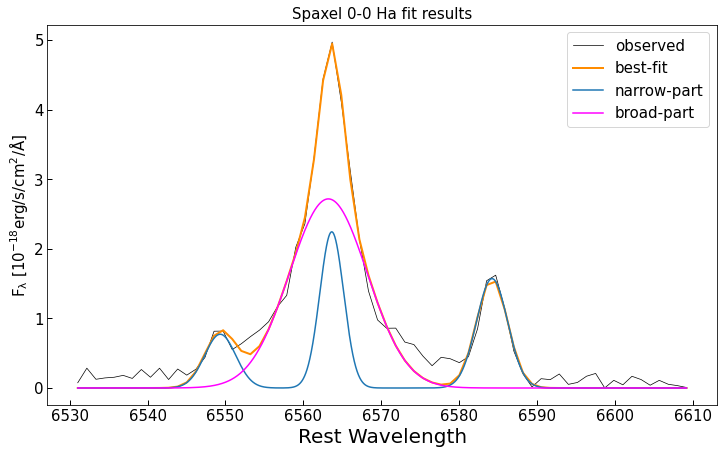

In [151]:
emline_fit(pp_wave,spec_flux_Ha,spec_err_Ha,spec_con_Ha,
            plot=True,savefig=False,mode='Ha',maxfev=500000)

In [147]:
EW = dict((key, value) for key, value in fit_flux.items() if 'EW' in key)
EW

{'NII[6548]_EW': 4.0039762470322255,
 'Ha[6563]_EW': 8.945606496203705,
 'NII[6583]_EW': 8.144745279579631,
 'Ha[6563]_broad_EW': 35.21104521873493}

In [138]:
sigle_line_fit(pp_wave,spec_flux_Ha,spec_err_Ha,spec_con_Ha, maxfev=10000, mode='O3b')

(['OIII[5007]'],
 {'OIII[5007]_para': array([2.96862596e+02, 5.00768138e+03, 1.24398075e+00]),
  'OIII[5007]_broad_para': array([1.22498021e+02, 5.00579970e+03, 3.02515192e+00]),
  'OIII[5007]_perr': array([27.21602506,  0.09275923,  0.11662512]),
  'OIII[5007]_broad_perr': array([22.83543758,  0.47039255,  0.25218536]),
  'fit_Chi2': 799.5842323695354,
  'fit_rChi2': 4.25310761898689},
 {'OIII[5007]_flux': 925.6761532203952,
  'OIII[5007]_broad_flux': 920.291265784264,
  'OIII[5007]_fluxerr': 53.2845117530855,
  'OIII[5007]_broad_fluxerr': 59.73528706811504,
  'OIII[5007]_velocity': 50.413633256213636,
  'OIII[5007]_broad_velocity': {'v50': -62.3327857153399,
   'v80': -527.621094595324},
  'OIII[5007]_EW': 10.29878803573211,
  'OIII[5007]_broad_EW': 10.238877435131615})

# TEST

In [4]:
from pkg.MUSE_data_reduce import MUSE
test = MUSE.MUSE(sdssj0228,z=0.072)

  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
